In [1]:
# full import

# load/handling data
import numpy as np
import pandas as pd
from sklearn import datasets

np.random.seed(42)

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# model selection
from sklearn.model_selection import train_test_split

#validations
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# suppose you ask a complex question to thousands of random people, then aggregate their answers
# in many cases, you will find that this aggregated answer is better than an expert's answer
# this is called 'the wisdom of the crowd'
# similarly, if you aggregate the predictions of a group of predictions (such as classifiers or regressions)
# you will often get better predictions than with the best individual predictor

# a group of predictors is called an 'ensemble'
# thus, this technique is called 'Ensemble Learning'
# and an Ensemble Learning algorithm is called an 'Ensemble Method'

In [3]:
# for example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set
# to make predictions, you just obtain the predictions of all individual trees, the predict the class that gets the most votes
# such an ensemble of Decision Trees is called a 'Random Forest'
# and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today

# moreover, as we discussed in Chapter 2, you will often use Ensemble methods near the end of a project
# once you have already build a few good predictors, to combine them into an even better predictor
# in fact, the winning solutions in Machine Learning competitions often involve several Ensemble methods

In [4]:
# in this chapter, we will discuss the most popular Ensemble methods, including:
#   # bagging
#   # boosting 
#   # stacking 
#   # and a few others
# we will also explore Random Forests

# Voting Classifiers


Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have:
- a Logistic Regression classifier
- an SVM classifier
- a Random Forest classifier
- a K-Nearest Neighbors classifier
- and perhaps a few more...


A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a **hard voting** classifier.


Somewhat suprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. 
- In fact, even if each classifier is a **weak learner** (meaning it does only slightly better than random guessing)
- The ensemble can still be a **strong learner** (achieving high accuracy)
- Provide there are sufficient number of weak learners and they are sufficiently diverse.


How is this possible? the following analogy can help shed some light on this mystery:
- Suppose you have a slightly biased coin (51% heads and 49% tails).
- If you toss 1000 times, you will get more or less 510 heads and 490 tails, and hence a majority of heads.
- If you do the maths, you will find that the probability of obtaining a majority of heads after 1000 tosses is close to 75%.
- The more you toss the coin, the higher the probability (e.g with 10000 tosses the probability climbs over 97%).
- This is due to the **law of large numbers**: as you keep tossing the coin, the ratio gets closer and closer to the probability of heads (51%).


Similarly:
- Suppose you build an ensemble containing 1000 classifiers that are individually correct only 51% of the time (barely better than random guessing):
- If you predict the majority voted class, you can hope for up to 75% accuracy.
- However, this is only true if all classifiers are: 
    - Perfectly independent.
    - Making uncorrelated errors. 
    - Which is clearly not the case since they are trained on the same data.
    - They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing ensemble's accuracy.


If all classifiers are able to estimate class probabilities (i.e. they have a predict_proba() method), then you can tell scikit-learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**.
- It often achieves higher performance than **hard voting** because it gives more weight to highly confident votes.
- All you need to do is: 
    - Replace the `voting = hard` with `voting = soft`. 
    - Ensure that all classifiers can estimate class probabilities.
        - Note that this is not the case of the `SVC` class by default.
        - So you need to set its `probability` hyperparameter to `True`.
        - This will make the `SVC` class: 
            - Use cross-validation to estimate class probabilities
            - Slowing down training.
            - Add `predict_proba()` method.

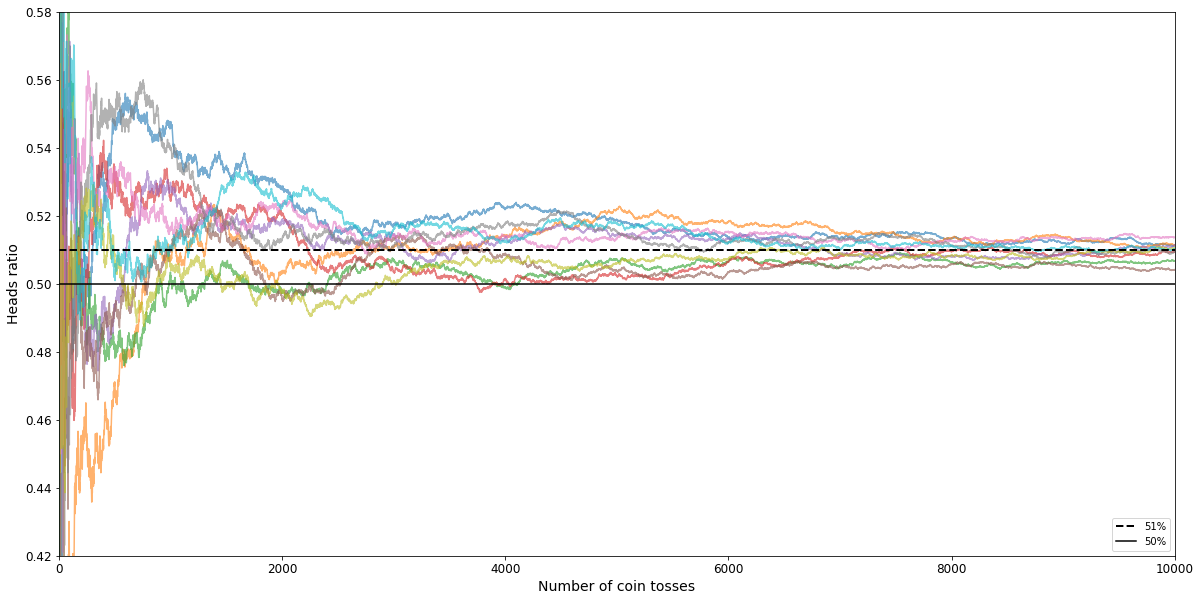

In [5]:
# this figure shows 10 series of biased coin tosses
# you can see as the number of tosses increases, the ratio of heads approaches 51%
# eventually all 10 series end up so close to 51% that they are considered above 50%

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(20, 10))
plt.plot(cumulative_heads_ratio, alpha=0.6)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
_ = plt.axis([0, 10000, 0.42, 0.58])

In [6]:
# this code creates and trains a voting classifier in scikit-learn
# compose of three diverse classifiers
# the training set is the moons dataset

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# create and train ensembles
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# create a voting 
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
# let's look at each classifier's accuracy on the test set

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
# there you have it, the voting class slightly outperforms all the individual classifiers

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [8]:
# soft voting

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [9]:
# validate the accuracy
# you can see that soft voting perform slightly better than hard voting

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting


Ways to get a diverse set of classifiers are: 
- Use very different training algorithms, as just discussed.
- Use the same training algorithm for every predictor, but to train them on different random subsets of the training set.
    - When sampling is performed **with replacement**, this method is called **bagging** (short for *bootstrap aggregating*).
    - When sampling is performed **without replacement**, it is called **pasting**.
- In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors.
- But only bagging allows training instances to be sampled several times for the same predictor.    


Once all predictors are trained, the ensemble can make a prediction for a new instance by: 
- Aggregating the predictions of all predictors.
- The aggregation function is typically the **statistical mode**:
    - (i.e. the most frequent prediction, just like a hard voting classifier for classification, or the average for regression).
- Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.
- Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original dataset.


Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.

---

## Bagging and Pasting in Scikit-Learn


Scikit-Learn offers a simple API for both bagging and pasting with:
- The `BaggingClassifier` class for classification.
- The `BaggingRegressor` class for regression.

In [10]:
# the following code trains an ensemble of 500 Decision Tree classifiers
# each trained on 100 training instances randomly sampled from the training set with replacement (bagging)
#   # (this is an example of bagging, if you want pasting instead, just type "bootstrap=False")
# the "n_jobs" parameter tells scikit-learn the number of CPU cores to use for training and predictions 
#   # (-1 tells scikit-learn to use all available cores)

# note:
#   # the BaggingClassifier automatically performs soft voting instead of hard voting 
#   # if the base classifier can estimate class proba‐bilities (i.e., if it has a predict_proba() method)
#   # which is the case with Decision Trees classifiers

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1
)

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

0.856


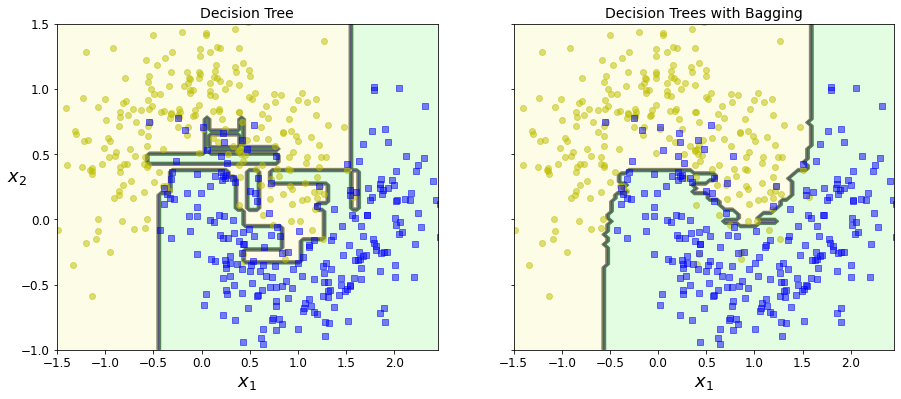

In [11]:
# this figure compares the decision boundary of a single Decision Tree with the bagging ensemble of 500 Trees
# both trained on the moons dataset

from matplotlib.colors import ListedColormap

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
_ = plt.ylabel("")

# as you can see, the ensemble's predictions will likely generalize much better than the single Decision Tree's predictions
# the ensemble has a comparable bias but smaller variance
#   # (it makes roughly the same number of errors on the training sets, but the decision boundary is less irregular)

# bootstraping introduces a bit more diversity in the subsets that each predictor is trained on
# so bagging ends up with a slightly higher bias and pasting 
# but this also means that predictors end up being less correlated so the ensemble's variance is reduced
# overall, bagging often results in better models, which explain why it is generally preferred
# however, if you have spare time and CPU power you can use cross-validation to evaluate bot bagging and pasting and select the one that works best

## Out-of-Bag Evaluation


With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. 
- By default a `BaggingClassifier` samples $m$ training instances with replacement (`bootstrap=True`).
    - Where $m$ is the size of the training set. 
- This means that only about 63% of the training instances are sampled on average for each predictor.
- The remaining 37% of the training instances that are not sampled are called **out-of-bag** (oob) instances.
    - Note that they are not the same 37% for all predictors.


Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. 
- You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In [12]:
# in sklearn, you can set "oob_score=True" when creating a BaggingClassifier to request an automatic oob evaluation after training
# the resulting evaluation score is available through the 'oob_score_' attribute

# the following code demonstrate this
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40
)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_ # this result shows the accuracy that the Bagging classifier would achieve on the test set

0.8986666666666666

In [13]:
# let's verify the score

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred) # close enough

0.912

In [14]:
# the oob decision function for each training instance is also avaiable through the 'obb_decision_function_' attribute
# in this case (since the base estimator has a predict_proba() method) 
# the decision function returns the class probabilities for each training instance

bag_clf.oob_decision_function_[:10]

# for example, the decision function estimate the first training instance has a:
#   # 67.7% of belonging to the positive class
#   # 32.3% of belonging to the negative class

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637]])

# Random Patches and Random Subspaces


The `BaggingClassifier` class supports sampling the features as well. This is controlled by 2 hyperparameters:
- `max_features`.
- `bootstrap_features`.
- They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling.
- Thus, each predictor will be trained on a random subset of the input features.


This is particularly useful when you're dealing with high-dimensional inputs:
- Sampling both training instances and features is called the **Random Patches Method**.
- Keeping all training instances (i.e. `bootstrap=False` and `max_samples=1.0`) but sampling features (i.e. `bootstrap_features=True` and/or `max_features < 1.0`) is called the **Random Subspace Method**.


Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

---

# Random Forests


As we have discussed, a Random Forest is an ensemble of Decision Trees:
- Generally trained via the bagging method (or sometimes pasting).
- Typically with `max_samples` set to the size of the training set. 
- Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees (similarly, there is a `RandomForestRegressor` class for regression tasks).


With a few exceptions, a `RandomForestClassifier` has:
- All the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown).
- All the hyperparameters of `BaggingClassifier` to control the ensemble itself.


The Random Forest algorithm introduces extra randomness when growing trees:
- Instead of searching for the very best feature when splitting a node.
- It searches for the best feature among a random subset of features.
- This result in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model.

In [15]:
# this code traings a RandomForest classifier with 500 trees (each limited to maximum 16 nodes)
# using all available CPU cores

from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [16]:
# the following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt',
                                                        max_leaf_nodes=16),
                  n_estimators=500, random_state=42)

In [17]:
y_pred_bag = bag_clf.predict(X_test)
y_pred_rf = rnd_clf.predict(X_test)

np.sum(y_pred_bag == y_pred_rf) / len(y_pred_bag) # very similar predicitions

1.0

## Extra-Trees


When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier).
- It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).
- A forest of such extremely random trees is simply called an **Extremely Randomized Trees** ensemble (or **Extra-Trees** for short).
- Once again, this trades more bias for a lower variance.
- It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.
- You can create an Extra-Trees classifiers using Scikit-Learn's `ExtraTreeClassifier` class. Its API is identical to the `RandomForestClassifier` class.
- Similarly, the `ExtraTreeRegressor` class has the same API as the `RandomForestRegressor` class.


**Note**:
- It is hard to tell in advance whether a `RandomForestClassifier` will perform better or worse than an `ExtraTreeClassifier`. 
- Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid search).

---

## Feature Importance


Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature.
- Scikit-Learn measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest).
- More precisely, it is a weighted average, where each node's weight is equal to the number of training samples that are associated with it. (see Chapter 6).
- Scikit-Learn computes this score automatically for each feature after training.
- Then it scale the result so that the sum of all importances is equal to 1.
- You can access the result using the `feature_importances_` attribute.


**Note**:
-Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

In [18]:
# for example
# the following code trains a RandomForestClassifier on the iris dataset
# and output each feature's importance

iris = datasets.load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)


# it seems that the most important features are the petal length (44%) and petal width (42%)
# while sepal length and sepal width are rather unimportant in comparison (11% and 2%, respectively) 

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [19]:
# similarly, if you train a Random Forest classifier on the MNIST dataset 
# and plot each pixel's importance, you get the image represented in this plot

# first let's get the data
mnist = datasets.fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [20]:
# then let's train the model
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(random_state=42)

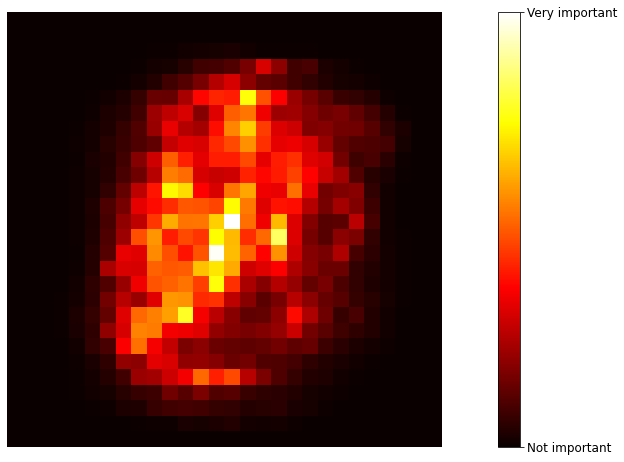

In [21]:
# finally let's plot the heatmap

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

fig, ax = plt.subplots(figsize=(20, 8))
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
_ = cbar.ax.set_yticklabels(['Not important', 'Very important'])

# Boosting


**Boosting** (originally called **hypothesis boosting**) refers to any Ensemble method that can combine several weak learners into a strong learner.
- The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.
- There are many boosting methods available, but by far the most popular are:
    - **AdaBoost** (short for **Adaptive Boosting**).
    - **Gradient Boosting**.

---

## AdaBoost


One way for a new predictor to correct its predecessor is:
- To pay a bit more attention to the training instances that the predecessor underfitted.
- This results in new predictors focusing more and more on the hard cases.
- This is the technique used by **AdaBoost**.


For example: To build an AdaBoost classifier
- A first base classifier is trained and used to make predictions on the training set.
- The relative weight of misclassified training instances is then increased.
- A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.


This sequential learning technique has some similarities with Gradient Descent:
- Except that instead of tweaking a single predictor's parameters to minimize the cost function.
- AdaBoost adds predictors to the ensemble, gradually making it better.


Once all predictors are trained:
- The ensemble makes predictions very much like bagging or pasting.
- Except that predictors have different weights depending on their overall accuracy on the weighted training set.

---

Let's take a closer look at the AdaBoost algorithm: 
1. Each instance weight $w^{(i)}$ is initially set to $\dfrac{1}{m}$.
- A first predictor is trained and its weight error rate $r_1$ is computed on the training set.


Weighted error rate of the $j^{th}$ predictor:
$%\usepackage{asmath}$
> $\large r_j = \dfrac{\underset{\hat{y}_j^{(i)} \not = y^{(i)}}{\displaystyle\sum_{i=1}^{m}w^{(i)}}}{\displaystyle\sum_{i=1}^{m}w^{(i)}}\normalsize \text{  , where }\hat{y}_j^{(i)} \text{ is the } j^{th} \text{ predictor's prediction for the } i^{th} \text{ instance.}$


2. The predictor's weight $\alpha_j$ is then computed using the equation below:


Predictor weight:
> $\alpha_j = \eta\log\dfrac{1-r}{r_j}$


**Notations**:
- $\eta$: is the learning rate hyperparameter (defaults to 1).
- The more accurate the predictor is, the higher its weight will be.
- If it is just guessing randomly, then its weight will be close to 0.
- However, if it is most often wrong (i.e. less accurate than random guessing), then its weight will be negative.
<br><br>

3. Next, the instance weights are updated using the following equation (the misclassified instances are boosted):


Weight update rule:
> $\text{for } i = 1, 2, ..., m \\ w^{(i)} \leftarrow \left\{\begin{array}{ll} w^{(i)} \hspace{38px} \text{ if }\hspace{5px} \hat{y_j}^{(i)}=y^{(i)} \\ w^{(i)} \exp\left(\alpha_j\right) \text{ if }\hspace{5px} \hat{y_j}^{(i)}\not =y^{(i)} \end{array}\right.$


<br><br>

4. Then, all the instance weights are normalized (i.e., divided by $\sum_{i=1}^{m}w^{(i)}$).
5. Finally, a new predictor is trained using the updated weights, and the whole process is repeated: 
    - The new predictor's weight is computed,
    - The instance weights are updated,
    - Then another predictor is trained, and so on.
6. The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

---

To make predictions: 
- AdaBoost simply computes the predictions of all the predictors.
- Weights them using the predictor weights $\alpha_j$.
- The predicted class is the one that receives the majority of weighted votes.


AdaBoost predictions:
$%usepackage{asmath}$
> $\large \hat{y}(\bold{x}) = \argmax\limits_k \underset{\hat{y}_j(\bold{x})=k}{\displaystyle\sum_{j=1}^{N}\alpha_j} \normalsize \hspace{5px}\text{where}\hspace{5px} N \hspace{5px}\text{is the number of predictors}$

---

Scikit-Learn actually uses a multiclass version of AdaBoost called **SAMME**: 
- Which stands for **Stagewise Additive Modeling using a Multiclass Exponential loss function**.
- When there are just 2 classes, SAMME is equivalent to AdaBoost.
- If the predictors can estimate probabilities (i.e. if they have a `predict_proba()` method):
    - Scikit-Learn can use a variant of SAMME called `SAMME.R` (the R stands for **Real**).
    - Which relies on class probabilities rather than predictions.
    - And generally performs better.

---

**Note**:
- There is one important drawback to this technique: It cannot be parallelized.
    - Since each predictor can only be trained after the previous one has been trained and evaluated.
    - As a result, it does not scale as well as bagging or pasting.
- If your AdaBoost ensemble is overfitting the training set, you can try:
    - Reducing the number of estimators
    - More strongly regularizing the base estimator.

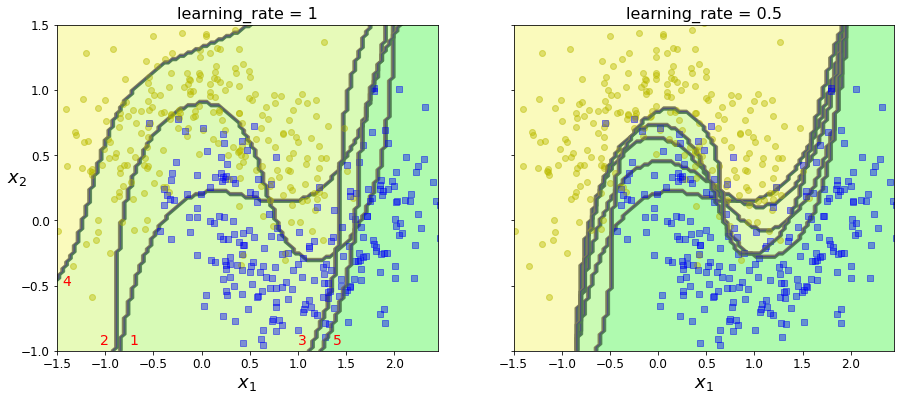

In [22]:
# this figure shows the decision boundaries of five consecutive predictors on the moons dataset
# (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel)
# the first classifier gets many instances wrong, so their weights get boosted
# the second classifier therefore does a better job on these instances, and so on


# the plot on the right represents the same sequence of predictors except that the learning rate is halved 
# (i.e. the misclassified instance weights are boosted half as much at every iteration)

from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum(
        ) / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.1)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14, color='r')
        plt.text(-1.05, -0.95, "2", fontsize=14, color='r')
        plt.text(1.0, -0.95, "3", fontsize=14, color='r')
        plt.text(-1.45, -0.5, "4", fontsize=14, color='r')
        plt.text(1.36,  -0.95, "5", fontsize=14, color='r')
    else:
        plt.ylabel("")

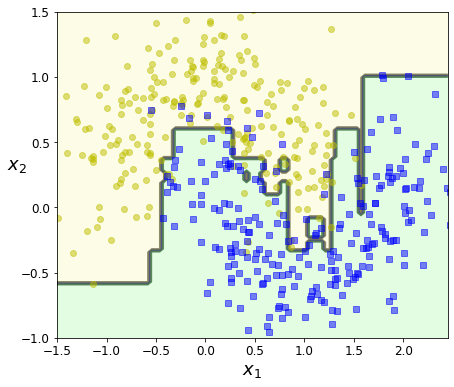

In [23]:
# the following code trains an AdaBoost classifier based on 200 Decision Stumps
# using sklearn's AdaBoostClassifier 
# a Decision Stump is a Decision Tree with 'max_depth=1'
# this is the default base estimator for the AdaBoostClassifier class

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(7, 6))
plot_decision_boundary(ada_clf, X, y)

## Gradient Boosting


Another very popular Boosting algorithm is **Gradient Boosting**. 
- Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor.
- However, instead of tweaking the instance weights at every iteration like AdaBoost, this method tries to fit the new predictor to the **residual errors** made by the previous predictor.

In [27]:
# let's go through a simple regression example using Decision Tree as the base predictors 
# this is called Gradient Tree Boosting, or Gradient Boosted Regression Tree (GBRT)

# first, let's fit a DecisionTreeRegressor to the training set (a noisy quadratic training set)

# create dataset
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [28]:
# now train a second DecisionTreeRegressor on the residual errors made by the first predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [29]:
# then we train a third regressor on the residual errors made by the second predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [30]:
# now we have an ensemble containing three trees
# it can make predictions on a new instance simply by adding up the predictions of all trees

X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

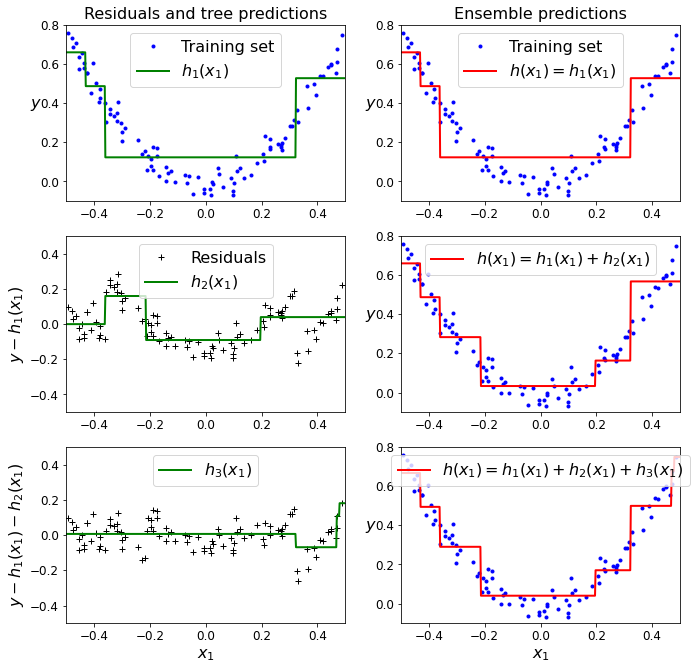

In [31]:
# this figure represents the predictions of these three trees in the left column
# and the ensemble's predictions in the right column

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
_ = plt.ylabel("$y$", fontsize=16, rotation=0)

# in the first row: 
#   # the ensemble has just one tree, 
#   # so its predictions are exactly the same as the first tree's predictions
# in the second row: 
#   # a new tree is trained on the residual errors of the first tree
#   # on the right, you can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees
# you can see that the ensemble's predictions gradually get better as trees are added to the ensemble

In [32]:
# a simple way to train GBRT ensembles is to use sklearn's GradientBoostingRegressor class
# much like the RandomForestRegressor class, it has hyperparameter to control the growth of Decision Trees
# as well as hyperparameters to control the ensemble training

# the following code creates the same ensemble as the previous one
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

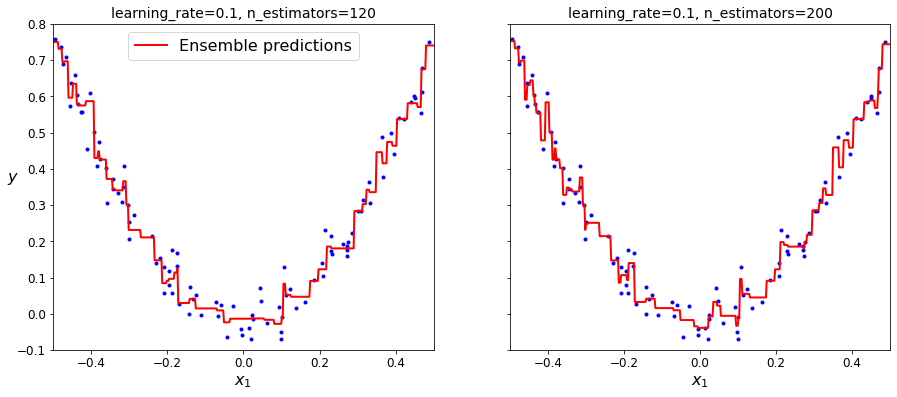

In [46]:
# the learning rate hyperparameter scales the contribution of each tree
# if you set it to a low value (such as 0.1): 
#   # you will need more trees in the ensemble to fit the training set
#   # but the predictions will usually generalize better
# this is a regularization technique called 'shrinkage'


# this figure shows two GBRT ensembles trained with a low learning rate
# the one on the left does not have enough trees to fit the training set
# the one on the right has too much trees and overfits the training set


gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(
    gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(
    gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
_ = plt.xlabel("$x_1$", fontsize=16)

In [39]:
# in order to find the optimal number of trees, you can use early stopping (see chapter 4)
# a simple way to implement this is to use the staged_predict() method:
#   # it returns an iterator over the predictions made by the ensemble at each stage of training (with 1 tree, 2 trees, 3 trees,...)

# the following code trains a GBRT ensemble with 120 trees
# then measures the validation error at each stage of training to find the optimal number of trees
# finally, trains another GBRT ensemble using the optimal number of trees

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split train/test data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# train the first GBRT
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# measures the validation error
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

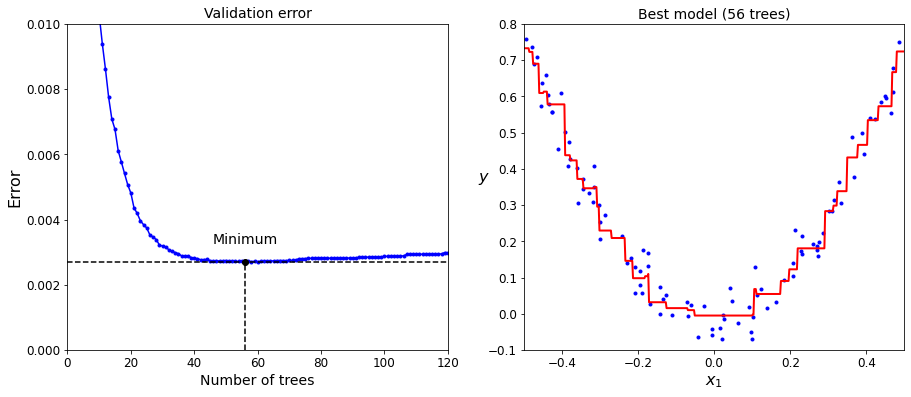

In [43]:
# the validation errors are represented on the left
# the best model's predictions are represented on the right

min_error = np.min(errors)
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
_ = plt.xlabel("$x_1$", fontsize=16)

In [47]:
# it is also possible to implement early stopping by actually stopping training early 
# (instead of training a large number of trees first and then looking back to find the optimal number)
# you can do so by setting 'warm_start=True'
# which makes sklearn keep existing trees when the fit() method is called, allowing incremental training

# the following code stops training when the validation error does not improve for five iterations in a row
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [49]:
# the GradientBoostingRegressor class also supports a 'subsample' hyperparameter 
# which specifies the fraction of training instances to be used for training each tree
# for example, if 'subsample=0.25', then each tree is trained on 25% of the training instances, selected randomly
# this trade a higher bias for a lower variance
# it also speeds up training considerably
# this technique is called 'Stochastic Gradient Boosting'

# it is worth noting that an optimized implementation of Gradient Boosting is available in the popular python library XGBoost
# which stands for Extreme Gradient Boosting
# XGBoost's API is quite similar to sklearn

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
print("Validation MSE:", mean_squared_error(y_val, y_pred))

Validation MSE: 0.004000408205406276


In [56]:
# xgboost also offers several nice features
# such as automatically taking care of early stopping

xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


# Stacking


The last Ensemble method we will discuss in this chapter is called **Stacking** (short for **Stacked Generalization**).
- It is based on a simple idea:
    - Instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don't we train a model to perform this aggregation?


For example (read book to see image):
- You have an ensemble of 3 predictors performing a regression task on a new instance.
- Each of the 3 predictors predict a different value (3.1, 2.7, and 2.9).
- Then the final predictor (called a **blender**, or a **meta learner**) takes these predictions as input and makes the final prediction (3.0).


To train a blender:
- A common approach is to use a hold-out set.
- The training set is split into 2 subsets.
- The first subset is used to train the predictors in the first layer (read book to see image).
- Next, the first layer predictors are used to make predictions on the second (held-out) set (read book to see image).
    - This ensures that the predictions are "clean", since the predictors never saw these instances during training.
- Now, for each instance in the hold-out set, there are 3 predicted values.
- We can create a new training set using these predicted values as input features (which makes this new training set 3-dimensional), and keeping the target values.
- The blender is trained on this new training set, so its learns to predict the target value given the first layer's predictions.


It is actually possible to train several different blenders this way, we get a whole layer of blenders.
- The trick is to split the training set into 3 subsets.
- The first subset is used to train the first layer.
- The second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer).
- The third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer).
- Once this is done, we can make a prediction for a new instance by going through each layer sequentially (read book to see image).

---

**Note**:
- Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard to implement.
- Alternatively, you can use an open source implementation such as **brew** (available at https://github.com/viisar/brew)